## weight-tuning_EB_LG
*   Epoch Bound : 在train 4000中
*   Learning Goal : loss要小於0.25

In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the Boston Housing dataset
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/新型學習演算法/diabetes.csv')

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [ ]:
print("dimension of data: {}".format(data.shape))

dimension of data: (768, 9)


In [ ]:
# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(data.drop('Outcome',axis = 1))
y = data['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
# 將數據轉換為 PyTorch 張量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)

In [ ]:
# 設定參數
D_in = X.shape[1]
H = 11
D_out = 1
print(f'Input layer: {D_in}')

# learning rate
learning_rate = 0.001

# learning goal
lg = 0.32

epoch_bound = 5000

Input layer: 8


In [ ]:
from collections import OrderedDict
# Define 2-layer neural network
model_EB_LG = torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(D_in, H)),
    ('relu', torch.nn.ReLU()),
    ('output', torch.nn.Linear(H, D_out))
])
)

In [ ]:
import time
# 損失函數和learning rate
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification without sigmoid
optimizer = optim.Adam(model_EB_LG.parameters(), lr=learning_rate)

train_losses = []

# Train the network
loss = float('Inf')
start_time = time.time()
for epoch in range(epoch_bound):
  if loss > lg:

    output = model_EB_LG(X_train)
    loss = criterion(output.view(-1), y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Collect the training loss values in list
    train_losses.append(loss.item())
  else:
    break


end_time = time.time()
duration = end_time - start_time
print(f"Training took {duration} seconds.")
print()
if epoch+1 < epoch_bound:
  print('Acceptable, Epoch {}, Loss: {}'.format(epoch+1, loss.item()))
else:
  print('Unacceptable, reach epochs {} but loss > {}.\nEpoch {}, Loss: {}'.format(epoch_bound, lg, epoch+1, loss.item()))



Training took 16.53605890274048 seconds.

Unacceptable, reach epochs 5000 but loss > 0.32.
Epoch 5000, Loss: 0.37196940183639526


In [ ]:
y_pred = model_EB_LG(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = torch.round(torch.sigmoid(y_pred))

# Calculate accuracy
total = len(y_test)
correct = 0
for i in range(len(y_pred_labels)):
  if y_pred_labels[i] == y_test[i]:
    correct += 1
accuracy = (correct / total) * 100

print(f"Accuracy: {accuracy}")

Accuracy: 76.62337662337663


## Clean the data and retrain it

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [ ]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


In [ ]:
def count_zero_num(feature):
  return len(data[data[feature]==0])
print('zero-values count')
for i in data.columns:
  temp = count_zero_num(i)
  print(f'{temp} ->{i}')

zero-values count
111 ->Pregnancies
5 ->Glucose
35 ->BloodPressure
227 ->SkinThickness
374 ->Insulin
11 ->BMI
0 ->DiabetesPedigreeFunction
0 ->Age
500 ->Outcome


### 把Pregnancies, SkinThickness, Insulin 0 的資料用mean取代

In [ ]:
data[['Pregnancies', 'SkinThickness', 'Insulin']] = data[['Pregnancies', 'SkinThickness', 'Insulin']].replace(0, np.nan)

In [ ]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,148,72,35.0,NaN,33.6,0.627,50,1
1,1.0,85,66,29.0,NaN,26.6,0.351,31,0
2,8.0,183,64,NaN,NaN,23.3,0.672,32,1
3,1.0,89,66,23.0,94.0,28.1,0.167,21,0
4,NaN,137,40,35.0,168.0,43.1,2.288,33,1


In [ ]:
data[['Pregnancies', 'SkinThickness', 'Insulin']] = data[['Pregnancies', 'SkinThickness', 'Insulin']].fillna(data[['Pregnancies', 'SkinThickness', 'Insulin']].mean())
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.000000,148,72,35.00000,155.548223,33.6,0.627,50,1
1,1.000000,85,66,29.00000,155.548223,26.6,0.351,31,0
2,8.000000,183,64,29.15342,155.548223,23.3,0.672,32,1
3,1.000000,89,66,23.00000,94.000000,28.1,0.167,21,0
4,4.494673,137,40,35.00000,168.000000,43.1,2.288,33,1


In [ ]:
print('Count zero-value in each column:')
print('-------------------------------')
for i in data.columns:
  temp = count_zero_num(i)
  print(f'{temp} ->{i}')

Count zero-value in each column:
-------------------------------
0 ->Pregnancies
5 ->Glucose
35 ->BloodPressure
0 ->SkinThickness
0 ->Insulin
11 ->BMI
0 ->DiabetesPedigreeFunction
0 ->Age
500 ->Outcome


將outcome = 0 , 1分開來看一下數據

In [ ]:
diabetes_0 = data[data['Outcome']==0]
diabetes_1 = data[data['Outcome']==1]

In [ ]:
print(len(diabetes_0), len(diabetes_1))

500 268


<Axes: xlabel='Outcome', ylabel='count'>

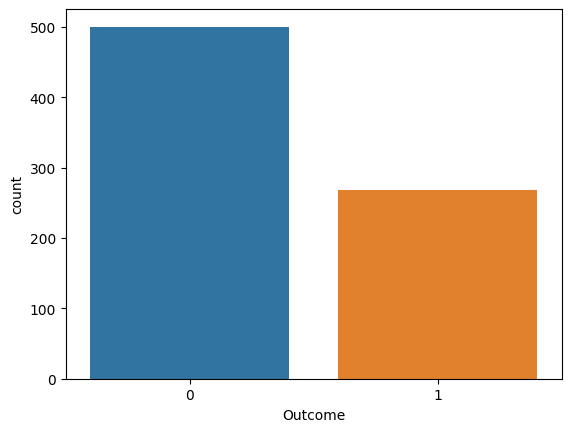

In [ ]:
import seaborn as sns
sns.countplot(data= data , x='Outcome',label='Count')

histogram of the "Age" variable in the "Outcome=0" dataset

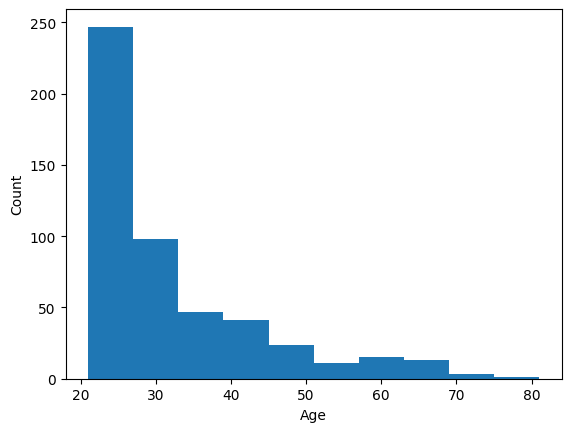

In [ ]:
plt.hist(diabetes_0['Age'] )
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

histogram of the "Age" variable in the "Outcome=1" dataset

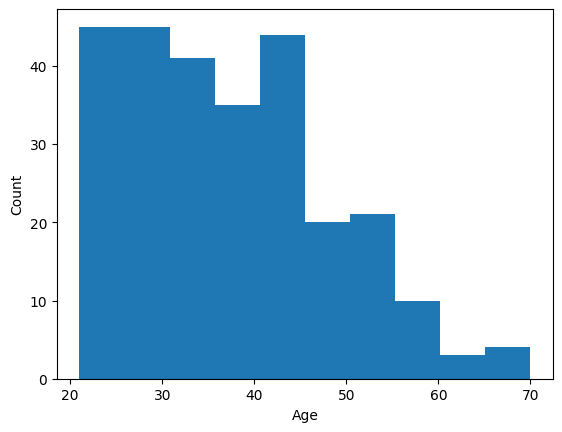

In [ ]:
plt.hist(diabetes_1["Age"])
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()

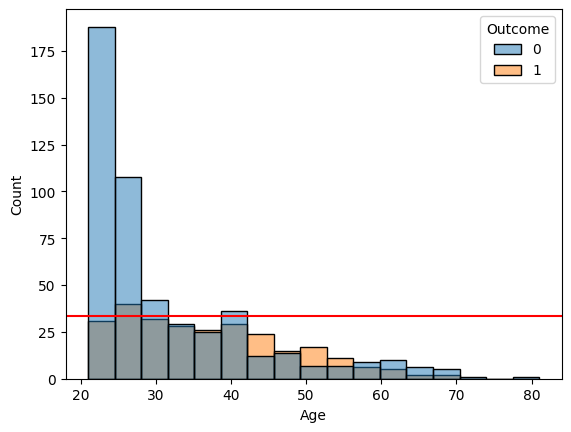

In [ ]:
sns.histplot(data=data, x='Age'  , hue='Outcome')
plt.xlabel('Age')
plt.ylabel('Count')
plt.axhline(np.mean(data['Age']), color='red', linestyle='solid')
plt.show()

<Axes: >

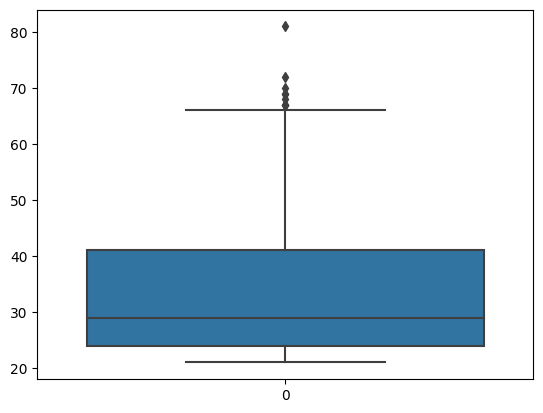

In [ ]:
sns.boxplot(data['Age'])

histogram of the "SkinThickness"

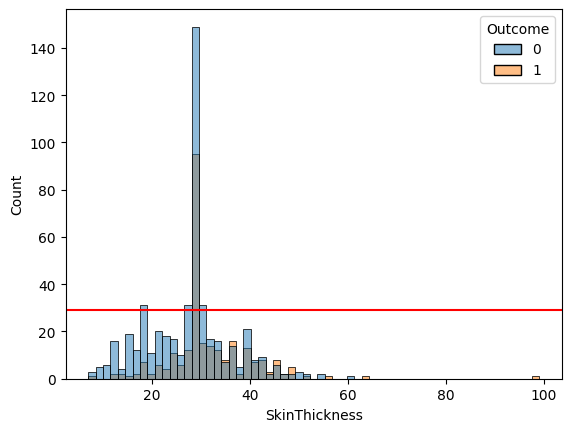

In [ ]:
sns.histplot(data=data, x='SkinThickness'  , hue='Outcome')
plt.xlabel('SkinThickness')
plt.ylabel('Count')
plt.axhline(np.mean(data['SkinThickness']), color='red', linestyle='solid')
plt.show()

In [ ]:
# average healthy people  SkinThickness
diabetes_0['SkinThickness'].mean()

27.76865064695009

In [ ]:
# average diabetics  SkinThickness
diabetes_1['SkinThickness'].mean()

31.736943747068715

The thickness of the skin of diabetics is higher than that of healthy people

<Axes: >

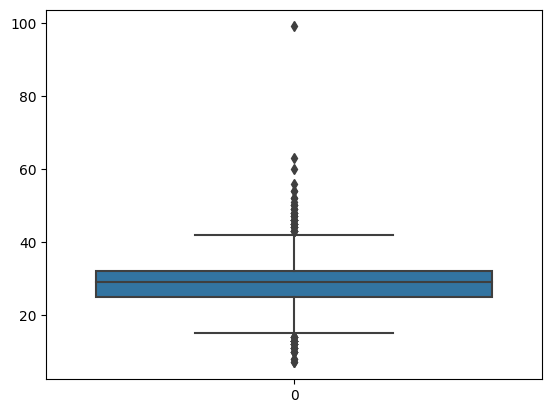

In [ ]:
sns.boxplot(data['SkinThickness'])

histogram of the "BMI"

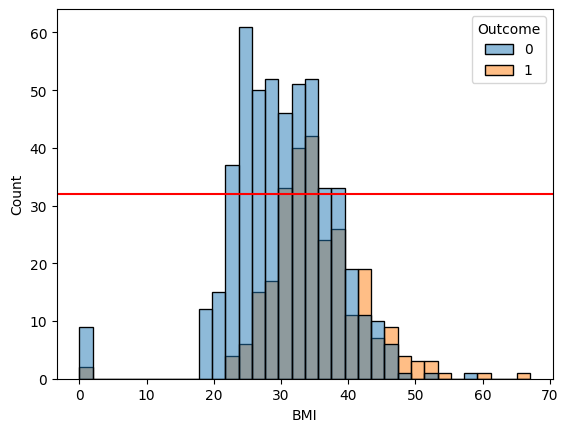

In [ ]:
sns.histplot(data=data, x='BMI'  , hue='Outcome')
plt.xlabel('BMI')
plt.ylabel('Count')
plt.axhline(np.mean(data['BMI']), color='red', linestyle='solid')
plt.show()

<Axes: >

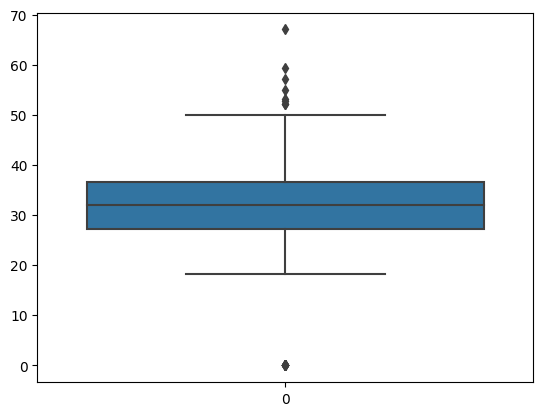

In [ ]:
sns.boxplot(data['BMI'])

In [ ]:
diabetes_0['BMI'].mean()

30.3042

In [ ]:
diabetes_1['BMI'].mean()

35.14253731343284

histogram of the "Pregnancies"



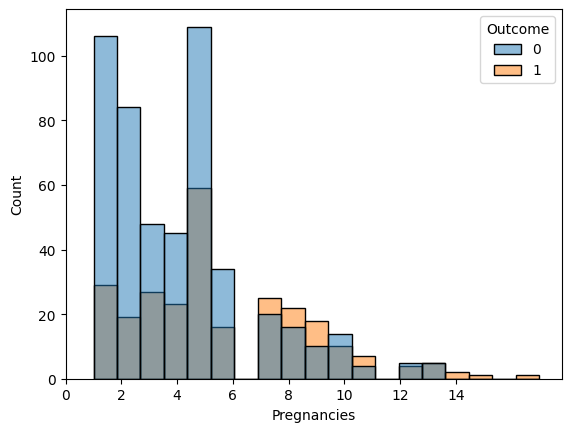

In [ ]:
sns.histplot(data=data, x='Pregnancies', hue='Outcome')
plt.xlabel('Pregnancies')
plt.ylabel('Count')
plt.xticks(range(0,15,2))
plt.show()

In [ ]:
diabetes_0['Pregnancies'].mean()

3.954222222222222

In [ ]:
diabetes_1['Pregnancies'].mean()

5.502975987641701

To compare  correlation between a target  and other features in absolute




In [ ]:
data.corr()['Outcome']

Pregnancies                 0.248263
Glucose                     0.466581
BloodPressure               0.065068
SkinThickness               0.215299
Insulin                     0.214411
BMI                         0.292695
DiabetesPedigreeFunction    0.173844
Age                         0.238356
Outcome                     1.000000
Name: Outcome, dtype: float64

In [ ]:
correlations = data.corr()['Outcome'].drop('Outcome')
sorted_correlations = correlations.abs().sort_values(ascending=False)
sorted_correlations

Glucose                     0.466581
BMI                         0.292695
Pregnancies                 0.248263
Age                         0.238356
SkinThickness               0.215299
Insulin                     0.214411
DiabetesPedigreeFunction    0.173844
BloodPressure               0.065068
Name: Outcome, dtype: float64

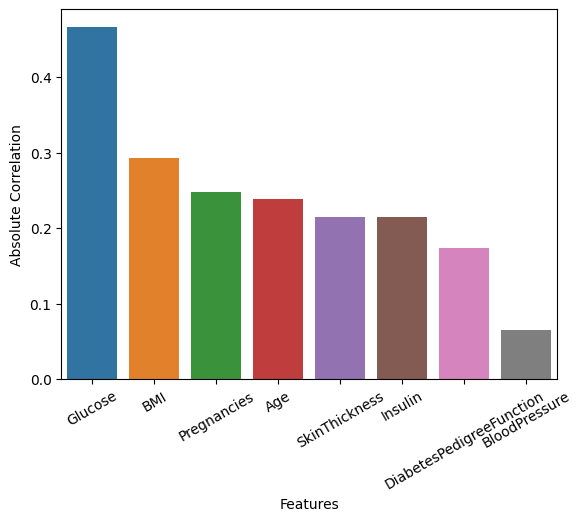

In [ ]:
sns.barplot(x=sorted_correlations.index, y=sorted_correlations)
plt.xticks(rotation=30)
plt.xlabel('Features')
plt.ylabel('Absolute Correlation')
plt.show()

### Train the model on the most important Features

In [ ]:
diabetes_corr = data[['Glucose', 'BMI', 'Pregnancies', 'Age', 'SkinThickness', 'Outcome']]
diabetes_corr

,Glucose,BMI,Pregnancies,Age,SkinThickness,Outcome
0,148,33.6,6.000000,50,35.00000,1
1,85,26.6,1.000000,31,29.00000,0
2,183,23.3,8.000000,32,29.15342,1
3,89,28.1,1.000000,21,23.00000,0
4,137,43.1,4.494673,33,35.00000,1
...,...,...,...,...,...,...
763,101,32.9,10.000000,63,48.00000,0
764,122,36.8,2.000000,27,27.00000,0
765,121,26.2,5.000000,30,23.00000,0
766,126,30.1,1.000000,47,29.15342,1


### drop Outlier noise data

In [ ]:
diabetes_corr

,Glucose,BMI,Pregnancies,Age,SkinThickness,Outcome
0,148,33.6,6.000000,50,35.00000,1
1,85,26.6,1.000000,31,29.00000,0
2,183,23.3,8.000000,32,29.15342,1
3,89,28.1,1.000000,21,23.00000,0
4,137,43.1,4.494673,33,35.00000,1
...,...,...,...,...,...,...
763,101,32.9,10.000000,63,48.00000,0
764,122,36.8,2.000000,27,27.00000,0
765,121,26.2,5.000000,30,23.00000,0
766,126,30.1,1.000000,47,29.15342,1


In [ ]:
diabetes_corr.quantile(0.25)

Glucose          99.0
BMI              27.3
Pregnancies       2.0
Age              24.0
SkinThickness    25.0
Outcome           0.0
Name: 0.25, dtype: float64

In [ ]:
Q1 = diabetes_corr.quantile(0.25) # Q1 for each column
Q3 = diabetes_corr.quantile(0.75) # Q3 for each column
IQR = Q3 - Q1

In [ ]:
# Identify  dataoutliers
outliers = diabetes_corr[((diabetes_corr < (Q1 - 1.5 * IQR)) | (diabetes_corr > (Q3 + 1.5 * IQR))).any(axis=1)]

In [ ]:
outliers

,Glucose,BMI,Pregnancies,Age,SkinThickness,Outcome
8,197,30.5,2.000000,53,45.00000,1
9,125,0.0,8.000000,54,29.15342,1
16,118,45.8,4.494673,31,47.00000,1
28,145,22.2,13.000000,57,19.00000,0
32,88,24.8,3.000000,22,11.00000,0
...,...,...,...,...,...,...
710,158,31.2,3.000000,24,13.00000,0
718,108,35.5,1.000000,24,46.00000,0
744,153,40.6,13.000000,39,37.00000,0
753,181,43.3,4.494673,26,44.00000,1


In [ ]:
# drop  the outliers from the data
train_clean = diabetes_corr.drop(outliers.index)
train_clean

,Glucose,BMI,Pregnancies,Age,SkinThickness,Outcome
0,148,33.6,6.000000,50,35.00000,1
1,85,26.6,1.000000,31,29.00000,0
2,183,23.3,8.000000,32,29.15342,1
3,89,28.1,1.000000,21,23.00000,0
4,137,43.1,4.494673,33,35.00000,1
...,...,...,...,...,...,...
762,89,22.5,9.000000,33,29.15342,0
764,122,36.8,2.000000,27,27.00000,0
765,121,26.2,5.000000,30,23.00000,0
766,126,30.1,1.000000,47,29.15342,1


visualizing the correlation between the variables in the diabetes

Text(0.5, 1.0, 'Correlation data')

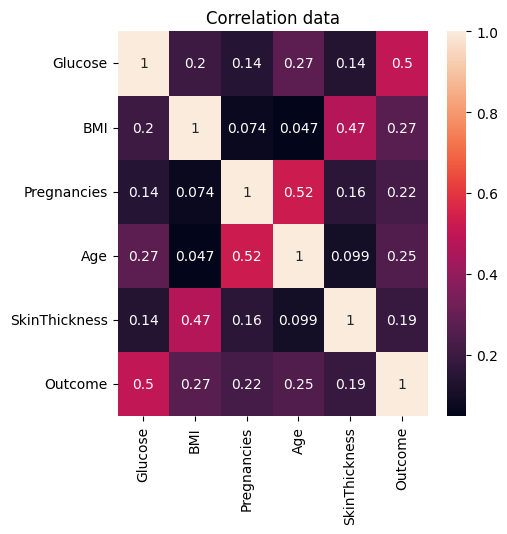

In [ ]:
plt.figure(figsize=(5,5))
sns.heatmap (np.abs(train_clean.corr()), annot=True)
plt.title ('Correlation data', fontsize=12)

### save df

In [ ]:
train_clean.to_pickle('/content/drive/MyDrive/Colab Notebooks/新型學習演算法/preprocess.pkl')

## split the data and train

In [ ]:
# Normalize the data
scaler = StandardScaler()
X = scaler.fit_transform(train_clean.drop('Outcome',axis = 1))
y = train_clean['Outcome']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

In [ ]:
# 將數據轉換為 PyTorch 張量
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.float32)
y_val = torch.tensor(y_val.values, dtype=torch.float32)

In [ ]:
# 設定參數
D_in = X_train.shape[1]
H = 100
D_out = 1
print(f'Input layer: {D_in}')

# learning rate
learning_rate = 0.01

# learning goal
lg = 0.4
pre_lg = 0.2

epoch_bound = 200

Input layer: 5


In [ ]:
from collections import OrderedDict
# Define 2-layer neural network
model_EB_LG = torch.nn.Sequential(OrderedDict([
    ('fc1', torch.nn.Linear(D_in, H)),
    ('relu', torch.nn.ReLU()),
    ('output', torch.nn.Linear(H, D_out))
])
)

# 損失函數和learning rate
criterion = nn.BCEWithLogitsLoss()  # Use BCEWithLogitsLoss for binary classification without sigmoid
optimizer = optim.Adam(model_EB_LG.parameters(), lr=learning_rate)

train_losses = []
'''best_loss = float('inf')
patience = 5  # Number of epochs to wait for improvement
counter = 0  # Counter for early stopping'''
# Train the network
loss = float('Inf')
start_time = time.time()
for epoch in range(epoch_bound):
  if loss > pre_lg:

    output = model_EB_LG(X_train)
    loss = criterion(output.view(-1), y_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Validation phase
    model_EB_LG.eval()
    with torch.no_grad():
      val_outputs = model_EB_LG(X_val)
      val_loss = criterion(val_outputs.view(-1), y_val)

    # Collect the training loss values in list
    train_losses.append(loss.item())
    '''# Check for early stopping
    if val_loss < best_loss:
      best_loss = val_loss
      counter = 0
    else:
      counter += 1
      if counter >= patience:
        print("Early stopping. No improvement for {} epochs.".format(patience))
        break'''
  else:
    break


end_time = time.time()
duration = end_time - start_time
print(f"Training took {duration} seconds.")
print()
if epoch+1 < epoch_bound:
  print('Acceptable, Epoch {}, Loss: {}'.format(epoch+1, loss.item()))
else:
  print('Unacceptable, reach epochs {} but loss > {}.\nEpoch {}, Loss: {}'.format(epoch_bound, pre_lg, epoch+1, loss.item()))



Training took 0.8929364681243896 seconds.

Unacceptable, reach epochs 200 but loss > 0.2.
Epoch 200, Loss: 0.2401001900434494


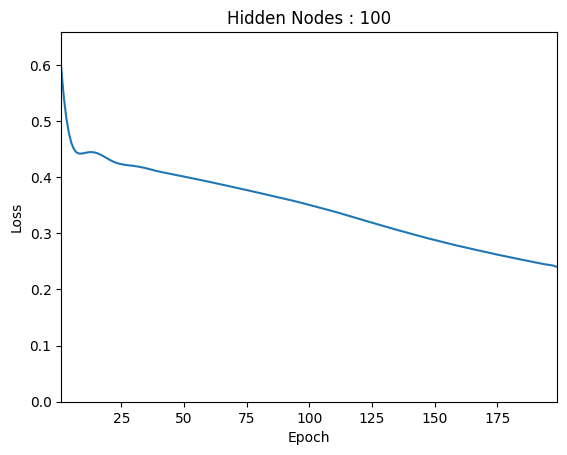

In [ ]:
# Plot the loss curve
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.title(f'Hidden Nodes : {H}')
plt.xlim(1, epoch)
plt.ylim(0, max(train_losses))
plt.show()

In [ ]:
y_pred = model_EB_LG(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = torch.round(torch.sigmoid(y_pred))

# Calculate accuracy
total = len(y_test)
correct = 0
for i in range(len(y_pred_labels)):
  if y_pred_labels[i] == y_test[i]:
    correct += 1
accuracy = (correct / total) * 100

print(f"Accuracy: {accuracy}")

Accuracy: 66.40625


In [ ]:
torch.save(model_EB_LG, 'Acc_SLFN.pt') # 存下 weight-tuning_LG_UA 的所有參數，當作 network-tuning 的 Acceptable SLFN

## Network-tuning

In [ ]:
model_1 = torch.load('Acc_SLFN.pt')

In [ ]:
import numpy as np

p = model_1.fc1.bias.shape[0]
k = 1
count = 0
while k <= p:
  torch.save(model_1, 'temp.pt')
  # Get the weight matrix of the first linear layer of the model
  weight_matrix = model_1.fc1.weight.detach().numpy()
  # Delete the k-th row from the weight matrix using NumPy's delete() function
  modified_weight_matrix = np.delete(weight_matrix, (k-1), axis=0)
  model_1.fc1.weight = nn.Parameter(torch.from_numpy(modified_weight_matrix).type(torch.Tensor))

  bias_matrix = model_1.fc1.bias.detach().numpy()
  modified_bias_matrix = np.delete(bias_matrix, k-1)
  model_1.fc1.bias = nn.Parameter(torch.from_numpy(modified_bias_matrix).type(torch.Tensor))

  weight_matrix_2 = model_1.output.weight.detach().numpy()
  modified_weight_matrix_2 = np.delete(weight_matrix_2, k-1, 1)
  model_1.output.weight = nn.Parameter(torch.from_numpy(modified_weight_matrix_2).type(torch.Tensor))

  output = model_1(X_train)
  w_loss = criterion(output.view(-1), y_train)
  w_loss.backward() # w的偏微分
  if w_loss > lg:
    print(f'\nRestore 第{count+1}個 hidden node, because it is an unacceptable SLFN')
    model_1 = torch.load('temp.pt')

    # regularizing
    optimizer.param_groups[0]['lr'] *= 0.7
    optimizer.step() # w'：w往偏微分的方向走一個step size
    print('Regularizing done.')
    k += 1
    count += 1
  else:
    print(f'\nDelete 第{count+1}個 hidden node, the loss = {w_loss:.4f}')
    print('Acceptable SLFN')
    # regularizing
    optimizer.param_groups[0]['lr'] *= 0.7
    optimizer.step() # w'：w往偏微分的方向走一個step size
    print('Regularizing done.')
    p -= 1
    count += 1


Delete 第1個 hidden node, the loss = 0.2444
Acceptable SLFN
Regularizing done.

Delete 第2個 hidden node, the loss = 0.2503
Acceptable SLFN
Regularizing done.

Delete 第3個 hidden node, the loss = 0.2530
Acceptable SLFN
Regularizing done.

Delete 第4個 hidden node, the loss = 0.2503
Acceptable SLFN
Regularizing done.

Delete 第5個 hidden node, the loss = 0.2570
Acceptable SLFN
Regularizing done.

Delete 第6個 hidden node, the loss = 0.2568
Acceptable SLFN
Regularizing done.

Delete 第7個 hidden node, the loss = 0.2546
Acceptable SLFN
Regularizing done.

Delete 第8個 hidden node, the loss = 0.3122
Acceptable SLFN
Regularizing done.

Delete 第9個 hidden node, the loss = 0.3089
Acceptable SLFN
Regularizing done.

Delete 第10個 hidden node, the loss = 0.3883
Acceptable SLFN
Regularizing done.

Delete 第11個 hidden node, the loss = 0.3769
Acceptable SLFN
Regularizing done.

Delete 第12個 hidden node, the loss = 0.3786
Acceptable SLFN
Regularizing done.

Restore 第13個 hidden node, because it is an unacceptable SLFN

In [ ]:
output = model_1(X_train)
loss = criterion(output.view(-1), y_train)
print(loss)

tensor(0.3873, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
y_pred = model_1(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = torch.round(torch.sigmoid(y_pred))

# Calculate accuracy
total = len(y_test)
correct = 0
for i in range(len(y_pred_labels)):
  if y_pred_labels[i] == y_test[i]:
    correct += 1
accuracy = (correct / total) * 100

print(f"Accuracy: {accuracy}")

Accuracy: 65.625


In [ ]:
print(len(model_1.fc1.weight.detach().numpy()))

48


In [ ]:
torch.save(model_1, 'network_tuning_model.pt')

## Find unacceptable cases
Two-class classification application
Use learing_goal_2 :


1.   If f(x,w) ≥ 𝛆, label=1
2.   If f(x,w) ≤ -𝛆, label=0
3.   If 𝛆 < f(x,w) < 1-𝛆, then x unknown



In [ ]:
𝛆 = 1.8
acceptable = []
unacceptable = []
acceptable_idx = []
unacceptable_idx = []
unknown = []
unknown_idx = []
for i in range(len(X_train)):
  output = model_EB_LG(X_train[i])
  if output >= 𝛆:
    if torch.round(torch.sigmoid(output)) == y_train[i]:
      acceptable.append(X_train[i])
      acceptable_idx.append(i)
    else:
      unacceptable.append(X_train[i])
      unacceptable_idx.append(i)
  elif output <= -𝛆:
    if torch.round(torch.sigmoid(output)) == y_train[i]:
      acceptable.append(X_train[i])
      acceptable_idx.append(i)
    else:
      unacceptable.append(X_train[i])
      unacceptable_idx.append(i)
  else:
    unknown.append(X_train[i])
    unknown_idx.append(i)
print(len(unacceptable))

5


In [ ]:
len(X_train) == len(unknown)+len(acceptable)+len(unacceptable)

True

In [ ]:
len(unknown)

158

## Isolating_Ri_ZG

In [ ]:
# random generate gama (8-dimensional tensor)
𝛾 = np.random.rand(D_in)
k = unacceptable[0]
for i in acceptable:
  if np.dot(𝛾, (i-k)) == 0:
    print('unacceptable 𝛾')
    break
print(f'This 𝛾={𝛾} is acceptable')

This 𝛾=[4.42815507e-04 3.88693812e-01 6.40142297e-01 4.33749418e-01
 3.07178864e-01] is acceptable


In [ ]:
type(𝛾)

numpy.ndarray

In [ ]:
import random
random_float = random.uniform(0, 1)
print(random_float)

0.684592273371827


In [ ]:
import random
flag = 1
while flag == 1:
  𝜁 = random.uniform(0, 1)
  for i in acceptable:
    if (𝜁 + np.dot(𝛾, (i-k)))*(𝜁 - np.dot(𝛾, (i-k))) >= 0:
      '''print('unacceptable 𝜁')'''
      break
    if i.tolist() == acceptable[-1].tolist():
      print(f'This 𝜁={𝜁} is acceptable')
      flag = 0

This 𝜁=0.01766527665001838 is acceptable


## 看要改幾個unacceptable case才可以達到learning goal

In [ ]:
accept = 0
count = len(unacceptable_idx)
while count > 0 and accept==0:
  for i in range(0,1):
    # 從第一個unacceptable case開始修正
    new_node_weights = 𝛾 # 初始化input to hidden nodes的weights
    new_node_bias_1 = 𝜁 - np.dot(𝛾, unacceptable[i])
    new_node_bias_2 = -np.dot(𝛾, unacceptable[i])
    new_node_bias_3 = -𝜁 - np.dot(𝛾, unacceptable[i])
    # activation of i hidden node corresponding to x_k
    hidden_layer_value = torch.matmul(unacceptable[0], model_EB_LG.fc1.weight.T)
    hidden_layer_Relu = torch.where(hidden_layer_value >= 0, hidden_layer_value, torch.zeros_like(hidden_layer_value)) # ReLU
    new_node_output_weights_1 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
    new_node_output_weights_2 = (-2*(y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T)))/𝜁
    new_node_output_weights_3 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
    '''print(new_node_weights)
    print(new_node_bias)
    print(new_node_output_weights)'''

    # 手動新增hidden node按照數學公式
    hidden_layer_params = model_EB_LG.fc1.weight.detach().numpy()
    hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
    hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
    hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
    '''print(hidden_layer_params)'''
    bias_matrix = model_EB_LG.fc1.bias.detach().numpy()
    new_bias = np.append(bias_matrix, new_node_bias_1)
    new_bias = np.append(new_bias, new_node_bias_2)
    new_bias = np.append(new_bias, new_node_bias_3)
    '''print(new_bias)'''
    weight_matrix_2 = model_EB_LG.output.weight.detach().numpy()
    modified_weight_matrix_2 = np.append(weight_matrix_2[0], new_node_output_weights_1)
    modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_2)
    modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_3)
    # Get the number of hidden nodes in the second layer
    h = model_EB_LG.fc1.bias.shape
    updated_weight_matrix_2 = np.empty((1,h[0]+(i+1)*3))
    updated_weight_matrix_2[0] = modified_weight_matrix_2
    '''print(updated_weight_matrix_2)'''
    # 將自訂的權重和偏差儲存在模型中
    model_EB_LG.fc1.weight = nn.Parameter(torch.from_numpy(hidden_layer_params).type(torch.Tensor))
    model_EB_LG.fc1.bias = nn.Parameter(torch.from_numpy(new_bias).type(torch.Tensor))
    model_EB_LG.output.weight = nn.Parameter(torch.from_numpy(updated_weight_matrix_2).type(torch.Tensor))

    print(f'調整第{i+1}個unacceptable case後的parameters setting')
    for name, param in model_EB_LG.named_parameters():
      print(name, param)
    output = model_EB_LG(X_train)
    loss = criterion(output.view(-1), y_train)
    print()
    print('loss = {}'.format(loss))
    print('==========================================================================')

    if loss <= lg:
      print('Acceptable model')
      accept = 1
      break
    else:
      print('Fail')

    acceptable = []
    unacceptable = []
    acceptable_idx = []
    unacceptable_idx = []
    unknown = []
    unknown_idx = []
    for i in range(len(X_train)):
      output = model_EB_LG(X_train[i])
      if output >= 𝛆:
        if torch.round(torch.sigmoid(output)) == y_train[i]:
          acceptable.append(X_train[i])
          acceptable_idx.append(i)
        else:
          unacceptable.append(X_train[i])
          unacceptable_idx.append(i)
      elif output <= -𝛆:
        if torch.round(torch.sigmoid(output)) == y_train[i]:
          acceptable.append(X_train[i])
          acceptable_idx.append(i)
        else:
          unacceptable.append(X_train[i])
          unacceptable_idx.append(i)
      else:
        unknown.append(X_train[i])
        unknown_idx.append(i)
    print('unacceptable cases count:',len(unacceptable))
    print(unacceptable_idx)
    print()
    count -= 1

調整第1個unacceptable case後的parameters setting
fc1.weight Parameter containing:
tensor([[-5.8010e-01, -1.0831e-01,  1.0858e+00, -3.5208e-01,  3.9705e-01],
        [ 7.1947e-01,  3.3285e-01, -1.4611e+00,  6.2811e-01, -1.8450e-01],
        [ 5.7179e-01, -5.3758e-02,  2.0376e-01, -3.0461e-01, -4.1525e-04],
        [ 8.2921e-02,  3.1534e-01, -1.7706e-01,  5.0889e-02, -7.0172e-01],
        [ 7.5716e-02,  2.2896e-01, -1.2835e+00,  2.1851e-01, -4.0501e-01],
        [ 3.5300e-02,  8.4425e-03, -3.3749e-01, -1.7435e-01, -7.1447e-01],
        [-1.9445e-01, -6.4421e-02, -6.3261e-01, -2.7051e-01, -6.8947e-01],
        [ 5.9172e-01,  6.7946e-01, -4.9810e-01,  1.1025e+00, -7.7866e-01],
        [-7.1037e-01,  5.1521e-01,  2.1813e-01, -1.5445e-01, -9.5381e-01],
        [-3.0779e-01,  1.1595e+00,  5.2553e-01,  1.0716e+00, -2.8375e-01],
        [ 6.9014e-01, -1.3083e+00,  3.0049e-01, -1.5341e-01, -6.2237e-01],
        [-8.0446e-01,  1.7839e-01, -5.3287e-01,  1.7287e-01,  6.8788e-01],
        [ 4.3659e-01, -7

In [ ]:
torch.save(model_EB_LG, 'after_Anologizing_SLFN.pt') # 存下 weight-tuning_LG_UA 的所有參數，當作 network-tuning 的 Acceptable SLFN

## Anologizing 後的 network-tuning

In [ ]:
model_1 = torch.load('after_Anologizing_SLFN.pt')

In [ ]:
import numpy as np
model_1 = torch.load('after_Anologizing_SLFN.pt')

p = model_1.fc1.bias.shape[0]
k = 1
count = 0
while k <= p:
  torch.save(model_1, 'temp.pt')
  # Get the weight matrix of the first linear layer of the model
  weight_matrix = model_1.fc1.weight.detach().numpy()
  # Delete the k-th row from the weight matrix using NumPy's delete() function
  modified_weight_matrix = np.delete(weight_matrix, (k-1), axis=0)
  model_1.fc1.weight = nn.Parameter(torch.from_numpy(modified_weight_matrix).type(torch.Tensor))

  bias_matrix = model_1.fc1.bias.detach().numpy()
  modified_bias_matrix = np.delete(bias_matrix, k-1)
  model_1.fc1.bias = nn.Parameter(torch.from_numpy(modified_bias_matrix).type(torch.Tensor))

  weight_matrix_2 = model_1.output.weight.detach().numpy()
  modified_weight_matrix_2 = np.delete(weight_matrix_2, k-1, 1)
  model_1.output.weight = nn.Parameter(torch.from_numpy(modified_weight_matrix_2).type(torch.Tensor))

  output = model_1(X_train)
  w_loss = criterion(output.view(-1), y_train)
  w_loss.backward() # w的偏微分
  if w_loss > lg:
    print(f'\nRestore 第{count+1}個 hidden node, because it is an unacceptable SLFN')
    model_1 = torch.load('temp.pt')

    # regularizing
    optimizer.param_groups[0]['lr'] *= 0.7
    optimizer.step() # w'：w往偏微分的方向走一個step size
    print('Regularizing done.')
    k += 1
    count += 1
  else:
    print(f'\nDelete 第{count+1}個 hidden node, the loss = {w_loss:.4f}')
    print('Acceptable SLFN')
    # regularizing
    optimizer.param_groups[0]['lr'] *= 0.7
    optimizer.step() # w'：w往偏微分的方向走一個step size
    print('Regularizing done.')
    p -= 1
    count += 1


Restore 第1個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第2個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第3個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第4個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第5個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第6個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第7個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第8個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第9個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第10個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第11個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第12個 hidden node, because it is an unacceptable SLFN
Regularizing done.

Restore 第13個 hidden node, because it

In [ ]:
output = model_1(X_train)
loss = criterion(output.view(-1), y_train)
print(loss)

tensor(0.4395, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>)


In [ ]:
y_pred = model_1(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = torch.round(torch.sigmoid(y_pred))

# Calculate accuracy
total = len(y_test)
correct = 0
for i in range(len(y_pred_labels)):
  if y_pred_labels[i] == y_test[i]:
    correct += 1
accuracy = (correct / total) * 100

print(f"Accuracy: {accuracy}")

Accuracy: 77.34375


In [ ]:
print(len(model_1.fc1.weight.detach().numpy()))

19


## 𝛆設更緊，看能不能改成acceptable SLFN

In [ ]:
𝛆 = 2
acceptable = []
unacceptable = []
acceptable_idx = []
unacceptable_idx = []
unknown = []
unknown_idx = []
for i in range(len(X_train)):
  output = model_EB_LG(X_train[i])
  if output >= 𝛆:
    if torch.round(torch.sigmoid(output)) == y_train[i]:
      acceptable.append(X_train[i])
      acceptable_idx.append(i)
    else:
      unacceptable.append(X_train[i])
      unacceptable_idx.append(i)
  elif output <= -𝛆:
    if torch.round(torch.sigmoid(output)) == y_train[i]:
      acceptable.append(X_train[i])
      acceptable_idx.append(i)
    else:
      unacceptable.append(X_train[i])
      unacceptable_idx.append(i)
  else:
    unknown.append(X_train[i])
    unknown_idx.append(i)
print(len(unacceptable))

4


In [ ]:
# random generate gama (8-dimensional tensor)
𝛾 = np.random.rand(D_in)
k = unacceptable[0]
for i in acceptable:
  if np.dot(𝛾, (i-k)) == 0:
    print('unacceptable 𝛾')
    break
print(f'This 𝛾={𝛾} is acceptable')

This 𝛾=[0.42753    0.96759434 0.49509707 0.52300695 0.28143268] is acceptable


In [ ]:
type(𝛾)

numpy.ndarray

In [ ]:
import random
random_float = random.uniform(0, 1)
print(random_float)

0.9205458934220917


In [ ]:
import random
flag = 1
while flag == 1:
  𝜁 = random.uniform(0, 1)
  for i in acceptable:
    if (𝜁 + np.dot(𝛾, (i-k)))*(𝜁 - np.dot(𝛾, (i-k))) >= 0:
      '''print('unacceptable 𝜁')'''
      break
    if i.tolist() == acceptable[-1].tolist():
      print(f'This 𝜁={𝜁} is acceptable')
      flag = 0

This 𝜁=0.0010187425696494001 is acceptable


In [ ]:
accept = 0
while len(unacceptable_idx) > 0 and accept==0:
  for i in range(0,1):
    # 從第一個unacceptable case開始修正
    new_node_weights = 𝛾 # 初始化input to hidden nodes的weights
    new_node_bias_1 = 𝜁 - np.dot(𝛾, unacceptable[i])
    new_node_bias_2 = -np.dot(𝛾, unacceptable[i])
    new_node_bias_3 = -𝜁 - np.dot(𝛾, unacceptable[i])
    # activation of i hidden node corresponding to x_k
    hidden_layer_value = torch.matmul(unacceptable[0], model_EB_LG.fc1.weight.T)
    hidden_layer_Relu = torch.where(hidden_layer_value >= 0, hidden_layer_value, torch.zeros_like(hidden_layer_value)) # ReLU
    new_node_output_weights_1 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
    new_node_output_weights_2 = (-2*(y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T)))/𝜁
    new_node_output_weights_3 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
    '''print(new_node_weights)
    print(new_node_bias)
    print(new_node_output_weights)'''

    # 手動新增hidden node按照數學公式
    hidden_layer_params = model_EB_LG.fc1.weight.detach().numpy()
    hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
    hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
    hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
    '''print(hidden_layer_params)'''
    bias_matrix = model_EB_LG.fc1.bias.detach().numpy()
    new_bias = np.append(bias_matrix, new_node_bias_1)
    new_bias = np.append(new_bias, new_node_bias_2)
    new_bias = np.append(new_bias, new_node_bias_3)
    '''print(new_bias)'''
    weight_matrix_2 = model_EB_LG.output.weight.detach().numpy()
    modified_weight_matrix_2 = np.append(weight_matrix_2[0], new_node_output_weights_1)
    modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_2)
    modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_3)
    # Get the number of hidden nodes in the second layer
    h = model_EB_LG.fc1.bias.shape
    updated_weight_matrix_2 = np.empty((1,h[0]+(i+1)*3))
    updated_weight_matrix_2[0] = modified_weight_matrix_2
    '''print(updated_weight_matrix_2)'''
    # 將自訂的權重和偏差儲存在模型中
    model_EB_LG.fc1.weight = nn.Parameter(torch.from_numpy(hidden_layer_params).type(torch.Tensor))
    model_EB_LG.fc1.bias = nn.Parameter(torch.from_numpy(new_bias).type(torch.Tensor))
    model_EB_LG.output.weight = nn.Parameter(torch.from_numpy(updated_weight_matrix_2).type(torch.Tensor))

    print(f'調整第{i+1}個unacceptable case後的parameters setting')
    for name, param in model_EB_LG.named_parameters():
      print(name, param)
    output = model_EB_LG(X_train)
    loss = criterion(output.view(-1), y_train)
    print()
    print('loss = {}'.format(loss))
    print('==========================================================================')

    if loss <= lg:
      print('Acceptable model')
      accept = 1
      break
    else:
      print('Fail')

    acceptable = []
    unacceptable = []
    acceptable_idx = []
    unacceptable_idx = []
    unknown = []
    unknown_idx = []
    for i in range(len(X_train)):
      output = model_EB_LG(X_train[i])
      if output >= 𝛆:
        if torch.round(torch.sigmoid(output)) == y_train[i]:
          acceptable.append(X_train[i])
          acceptable_idx.append(i)
        else:
          unacceptable.append(X_train[i])
          unacceptable_idx.append(i)
      elif output <= -𝛆:
        if torch.round(torch.sigmoid(output)) == y_train[i]:
          acceptable.append(X_train[i])
          acceptable_idx.append(i)
        else:
          unacceptable.append(X_train[i])
          unacceptable_idx.append(i)
      else:
        unknown.append(X_train[i])
        unknown_idx.append(i)
    print('unacceptable cases count:',len(unacceptable))
    print(unacceptable_idx)
    print()

串流輸出內容已截斷至最後 5000 行。
         -5.6290e+03,  2.8145e+03,  2.8145e+03, -5.6290e+03,  2.8145e+03,
          2.8145e+03, -5.6290e+03,  2.8145e+03,  2.8145e+03, -5.6290e+03,
          2.8145e+03,  2.8145e+03, -5.6290e+03,  2.8145e+03,  2.8102e+03,
         -5.6204e+03,  2.8102e+03,  2.8102e+03, -5.6204e+03,  2.8102e+03,
          2.8102e+03, -5.6204e+03,  2.8102e+03,  2.8102e+03, -5.6204e+03,
          2.8102e+03,  2.8102e+03, -5.6204e+03,  2.8102e+03,  2.8102e+03,
         -5.6204e+03,  2.8102e+03,  2.8102e+03, -5.6204e+03,  2.8102e+03,
          2.8102e+03, -5.6204e+03,  2.8102e+03,  2.8102e+03, -5.6204e+03,
          2.8102e+03,  2.8102e+03, -5.6204e+03,  2.8102e+03,  2.8102e+03,
         -5.6204e+03,  2.8102e+03,  2.8116e+03, -5.6232e+03,  2.8116e+03,
          2.8116e+03, -5.6232e+03,  2.8116e+03,  2.8116e+03, -5.6232e+03,
          2.8116e+03,  2.8116e+03, -5.6232e+03,  2.8116e+03,  2.8116e+03,
         -5.6232e+03,  2.8116e+03,  2.8116e+03, -5.6232e+03,  2.8116e+03,
          2.8116e

KeyboardInterrupt: ignored

## X_text accuracy

In [ ]:
y_pred = model_EB_LG(X_test)

# Convert predicted probabilities to class labels
y_pred_labels = torch.round(torch.sigmoid(y_pred))

# Calculate accuracy
total = len(y_test)
correct = 0
for i in range(len(y_pred_labels)):
  if y_pred_labels[i] == y_test[i]:
    correct += 1
accuracy = (correct / total) * 100

print(f"Accuracy: {accuracy}")


Accuracy: 72.07792207792207


## Analogizing_Ri_LG2_SO_MU
### 從第一個unacceptable case開始修正

In [ ]:
model_EB_LG = torch.load('network_tuning_model.pt')

In [ ]:
for i in range(0,1):
  # 從第一個unacceptable case開始修正
  new_node_weights = 𝛾 # 初始化input to hidden nodes的weights
  new_node_bias_1 = 𝜁 - np.dot(𝛾, unacceptable[i])
  new_node_bias_2 = -np.dot(𝛾, unacceptable[i])
  new_node_bias_3 = -𝜁 - np.dot(𝛾, unacceptable[i])
  # activation of i hidden node corresponding to x_k
  hidden_layer_value = torch.matmul(unacceptable[0], model_EB_LG.fc1.weight.T)
  hidden_layer_Relu = torch.where(hidden_layer_value >= 0, hidden_layer_value, torch.zeros_like(hidden_layer_value)) # ReLU
  new_node_output_weights_1 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
  new_node_output_weights_2 = (-2*(y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T)))/𝜁
  new_node_output_weights_3 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
  '''print(new_node_weights)
  print(new_node_bias)
  print(new_node_output_weights)'''

  # 手動新增hidden node按照數學公式
  hidden_layer_params = model_EB_LG.fc1.weight.detach().numpy()
  hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
  hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
  hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
  '''print(hidden_layer_params)'''
  bias_matrix = model_EB_LG.fc1.bias.detach().numpy()
  new_bias = np.append(bias_matrix, new_node_bias_1)
  new_bias = np.append(new_bias, new_node_bias_2)
  new_bias = np.append(new_bias, new_node_bias_3)
  '''print(new_bias)'''
  weight_matrix_2 = model_EB_LG.output.weight.detach().numpy()
  modified_weight_matrix_2 = np.append(weight_matrix_2[0], new_node_output_weights_1)
  modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_2)
  modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_3)
  updated_weight_matrix_2 = np.empty((1,len(model_EB_LG.fc1.weight.detach().numpy())+(i+1)*3))
  updated_weight_matrix_2[0] = modified_weight_matrix_2
  '''print(updated_weight_matrix_2)'''
  # 將自訂的權重和偏差儲存在模型中
  model_EB_LG.fc1.weight = nn.Parameter(torch.from_numpy(hidden_layer_params).type(torch.Tensor))
  model_EB_LG.fc1.bias = nn.Parameter(torch.from_numpy(new_bias).type(torch.Tensor))
  model_EB_LG.output.weight = nn.Parameter(torch.from_numpy(updated_weight_matrix_2).type(torch.Tensor))

  print(f'調整第{i+1}個unacceptable case後的parameters setting')
  for name, param in model_EB_LG.named_parameters():
    print(name, param)
  output = model_EB_LG(X_train)
  loss = criterion(output.view(-1), y_train)
  print('\n')
  print('loss = {}'.format(loss))
  print('==========================================================================')

if loss <= lg:
  print('Acceptable model')
else:
  print('Fail')

調整第1個unacceptable case後的parameters setting
fc1.weight Parameter containing:
tensor([[ 1.7497e-01,  1.1968e+00, -8.6868e-01,  5.2307e-01, -3.3454e-01],
        [-8.4303e-01, -4.8934e-01, -2.2593e+00,  1.0407e-01, -3.3216e-01],
        [-1.3546e-01, -1.5077e+00,  1.3680e+00,  4.8095e-01,  4.0727e-01],
        [-4.7035e-01,  8.3859e-01, -1.3839e+00, -2.2749e-01,  1.3667e+00],
        [-1.7442e+00, -6.4691e-01, -2.6108e+00,  1.4407e-01, -7.9219e-01],
        [-2.0162e-01,  7.3557e-01,  1.2101e-01,  4.6341e-01,  1.7832e-01],
        [ 1.6354e-01, -6.5920e-01, -2.1447e-01, -2.8494e-02,  7.3148e-01],
        [ 1.1162e+00,  5.1775e-01, -8.3486e-01, -9.5795e-01,  1.3215e+00],
        [ 3.5160e-01,  1.1348e+00, -7.9992e-01, -1.3187e+00,  5.8006e-01],
        [ 5.6049e-02,  1.3212e+00,  2.4238e-01, -7.1269e-01, -4.8755e-01],
        [-2.7544e-01, -1.5033e-01,  8.5252e-01,  4.4498e-01, -3.1381e-01],
        [ 2.3433e-01,  3.9940e-01,  1.4917e+00,  7.4793e-01, -1.1716e+00],
        [ 4.3938e-01,  1

In [ ]:
acceptable = []
unacceptable = []
acceptable_idx = []
unacceptable_idx = []
unknown = []
unknown_idx = []
for i in range(len(X_train)):
  output = model_EB_LG(X_train[i])
  if output > 𝛆:
    if torch.round(torch.sigmoid(output)) == y_train[i]:
      acceptable.append(X_train[i])
      acceptable_idx.append(i)
    else:
      unacceptable.append(X_train[i])
      unacceptable_idx.append(i)
  elif output < -𝛆:
    if torch.round(torch.sigmoid(output)) == y_train[i]:
      acceptable.append(X_train[i])
      acceptable_idx.append(i)
    else:
      unacceptable.append(X_train[i])
      unacceptable_idx.append(i)
  else:
    unknown.append(X_train[i])
    unknown_idx.append(i)
print(len(unacceptable))

28


In [ ]:
unacceptable_idx

In [ ]:
acceptable = []
unacceptable = []
acceptable_idx = []
unacceptable_idx = []
unknown = []
unknown_idx = []
for i in range(len(X_train)):
  output = model_EB_LG(X_train[i])
  if output >= 𝛆:
    if torch.round(torch.sigmoid(output)) == y_train[i]:
      acceptable.append(X_train[i])
      acceptable_idx.append(i)
    else:
      unacceptable.append(X_train[i])
      unacceptable_idx.append(i)
  elif output <= -𝛆:
    if torch.round(torch.sigmoid(output)) == y_train[i]:
      acceptable.append(X_train[i])
      acceptable_idx.append(i)
    else:
      unacceptable.append(X_train[i])
      unacceptable_idx.append(i)
  else:
    unknown.append(X_train[i])
    unknown_idx.append(i)
print(len(unacceptable))

10


In [ ]:
unacceptable_idx

[64, 115, 156, 316, 324, 335, 351, 441, 475, 491]

### 用第二個unacceptable case修正model

In [ ]:
for i in range(0,1):
  # 從第一個unacceptable case開始修正
  new_node_weights = 𝛾 # 初始化input to hidden nodes的weights
  new_node_bias_1 = 𝜁 - np.dot(𝛾, unacceptable[i])
  new_node_bias_2 = -np.dot(𝛾, unacceptable[i])
  new_node_bias_3 = -𝜁 - np.dot(𝛾, unacceptable[i])
  # activation of i hidden node corresponding to x_k
  hidden_layer_value = torch.matmul(unacceptable[0], model_EB_LG.fc1.weight.T)
  hidden_layer_Relu = torch.where(hidden_layer_value >= 0, hidden_layer_value, torch.zeros_like(hidden_layer_value)) # ReLU
  new_node_output_weights_1 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
  new_node_output_weights_2 = (-2*(y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T)))/𝜁
  new_node_output_weights_3 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
  '''print(new_node_weights)
  print(new_node_bias)
  print(new_node_output_weights)'''

  # 手動新增hidden node按照數學公式
  hidden_layer_params = model_EB_LG.fc1.weight.detach().numpy()
  hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
  hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
  hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
  '''print(hidden_layer_params)'''
  bias_matrix = model_EB_LG.fc1.bias.detach().numpy()
  new_bias = np.append(bias_matrix, new_node_bias_1)
  new_bias = np.append(new_bias, new_node_bias_2)
  new_bias = np.append(new_bias, new_node_bias_3)
  '''print(new_bias)'''
  weight_matrix_2 = model_EB_LG.output.weight.detach().numpy()
  modified_weight_matrix_2 = np.append(weight_matrix_2[0], new_node_output_weights_1)
  modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_2)
  modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_3)
  updated_weight_matrix_2 = np.empty((1,H+(i+1)*3))
  updated_weight_matrix_2[0] = modified_weight_matrix_2
  '''print(updated_weight_matrix_2)'''
  # 將自訂的權重和偏差儲存在模型中
  model_EB_LG.fc1.weight = nn.Parameter(torch.from_numpy(hidden_layer_params).type(torch.Tensor))
  model_EB_LG.fc1.bias = nn.Parameter(torch.from_numpy(new_bias).type(torch.Tensor))
  model_EB_LG.output.weight = nn.Parameter(torch.from_numpy(updated_weight_matrix_2).type(torch.Tensor))

  print(f'調整第{i+1}個unacceptable case後的parameters setting')
  for name, param in model_EB_LG.named_parameters():
    print(name, param)
  output = model_EB_LG(X_train)
  loss = criterion(output.view(-1), y_train)
  print('\n')
  print('loss = {}'.format(loss))
  print('==========================================================================')

if loss <= lg:
  print('Acceptable model')
else:
  print('Fail')

調整第2個unacceptable case後的parameters setting
fc1.weight Parameter containing:
tensor([[-0.4294, -0.5413, -0.5504,  0.3812, -1.4949, -0.1351, -0.8694,  1.2358],
        [-1.0213, -0.3627,  0.1970, -0.4086,  0.2433, -0.3123, -0.1819, -1.4422],
        [-0.4053,  0.8297, -0.4579, -0.1478, -0.2852,  0.4405, -0.0337,  0.3097],
        [ 0.9144,  0.7410,  0.1643,  0.4742,  0.4254,  0.6694,  0.0473,  0.7995],
        [ 0.9144,  0.7410,  0.1643,  0.4742,  0.4254,  0.6694,  0.0473,  0.7995],
        [ 0.9144,  0.7410,  0.1643,  0.4742,  0.4254,  0.6694,  0.0473,  0.7995],
        [ 0.9144,  0.7410,  0.1643,  0.4742,  0.4254,  0.6694,  0.0473,  0.7995],
        [ 0.9144,  0.7410,  0.1643,  0.4742,  0.4254,  0.6694,  0.0473,  0.7995],
        [ 0.9144,  0.7410,  0.1643,  0.4742,  0.4254,  0.6694,  0.0473,  0.7995]],
       requires_grad=True)
fc1.bias Parameter containing:
tensor([ 0.4643, -0.0637,  0.7133,  1.4395,  1.4389,  1.4382,  0.9929,  0.9923,
         0.9916], requires_grad=True)
output.we

## 用第三個unacceptable case

In [ ]:
for i in range(2,11):
  # 從第一個unacceptable case開始修正
  new_node_weights = 𝛾 # 初始化input to hidden nodes的weights
  new_node_bias_1 = 𝜁 - np.dot(𝛾, unacceptable[i])
  new_node_bias_2 = -np.dot(𝛾, unacceptable[i])
  new_node_bias_3 = -𝜁 - np.dot(𝛾, unacceptable[i])
  # activation of i hidden node corresponding to x_k
  hidden_layer_value = torch.matmul(unacceptable[0], model_EB_LG.fc1.weight.T)
  hidden_layer_Relu = torch.where(hidden_layer_value >= 0, hidden_layer_value, torch.zeros_like(hidden_layer_value)) # ReLU
  new_node_output_weights_1 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
  new_node_output_weights_2 = (-2*(y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T)))/𝜁
  new_node_output_weights_3 = (y_train[unacceptable_idx[i]] - model_EB_LG.output.bias.detach().numpy() - np.dot(model_EB_LG.output.weight.detach().numpy(), hidden_layer_Relu.detach().numpy().T))/𝜁
  '''print(new_node_weights)
  print(new_node_bias)
  print(new_node_output_weights)'''

  # 手動新增hidden node按照數學公式
  hidden_layer_params = model_EB_LG.fc1.weight.detach().numpy()
  hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
  hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
  hidden_layer_params = np.vstack((hidden_layer_params, new_node_weights))
  '''print(hidden_layer_params)'''
  bias_matrix = model_EB_LG.fc1.bias.detach().numpy()
  new_bias = np.append(bias_matrix, new_node_bias_1)
  new_bias = np.append(new_bias, new_node_bias_2)
  new_bias = np.append(new_bias, new_node_bias_3)
  '''print(new_bias)'''
  weight_matrix_2 = model_EB_LG.output.weight.detach().numpy()
  modified_weight_matrix_2 = np.append(weight_matrix_2[0], new_node_output_weights_1)
  modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_2)
  modified_weight_matrix_2 = np.append(modified_weight_matrix_2, new_node_output_weights_3)
  updated_weight_matrix_2 = np.empty((1,H+(i+1)*3))
  updated_weight_matrix_2[0] = modified_weight_matrix_2
  '''print(updated_weight_matrix_2)'''
  # 將自訂的權重和偏差儲存在模型中
  model_EB_LG.fc1.weight = nn.Parameter(torch.from_numpy(hidden_layer_params).type(torch.Tensor))
  model_EB_LG.fc1.bias = nn.Parameter(torch.from_numpy(new_bias).type(torch.Tensor))
  model_EB_LG.output.weight = nn.Parameter(torch.from_numpy(updated_weight_matrix_2).type(torch.Tensor))

  print(f'調整第{i+1}個unacceptable case後的parameters setting')
  for name, param in model_EB_LG.named_parameters():
    print(name, param)
  output = model_EB_LG(X_train)
  loss = criterion(output.view(-1), y_train)
  print('\n')
  print('loss = {}'.format(loss))
  print('==========================================================================')

if loss <= lg:
  print('Acceptable model')
else:
  print('Fail')